In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ---- ---------------------------------- 30.7/294.9 kB 262.6 kB/s eta 0:00:02
   ----- --------------------------------- 41.0/294.9 kB 245.8 kB/s eta 0:00:02
   --------- ----------------------------- 71.7/294.9 kB 357.2 kB/s eta 0:00:01
   ---------------------- --------------- 174.1/294.9 kB 807.1 kB/s eta 0:00:01
   ------------------------------------ --- 266.2/294.9 kB 1.0 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 1.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# get_ipython().magic('matplotlib inline')

# %tensorflow_version 2.x
import tensorflow as tf

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Bidirectional

from tensorflow.python.keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# # user-defined libraries
# import utilities.datapreprocessing as dp
# import utilities.performancemetrics as pm
# import utilities.simpleplots as sp

from numpy.random import seed
seed(1)

SEED = 123  # used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

from pylab import rcParams
rcParams['figure.figsize'] = 8, 6
plt.rcParams.update({'font.size': 22})

In [2]:
df = pd.read_csv("Imputed_New-Dataset_Aiops_3.csv")
df.head(n=5)  # visualize the data.

,hostid,clock,Download_Speed,Reach_Time,Time_to_First_Byte,HTTP_Probe_Duration,Page_Load_Time,DNS_Query_Time,Status_ID,Failed_step_of_scenario_WEB_HEALTH_CHECK,...,Available_memory_in_percent,Memory_utilization,System_local_time,Space_Available,Boot_Space_Available,Available_memory,Total_memory,website_events,server_events,event_value
0,10640,10/1/2024 18:19,58357.46520,0.00559,0.00526,2.073,0.001847,25.8,1,1.0,...,67.063513,32.936487,1727786986,12294438912,719982592,673267712.0,1003925504,0,0,20.279284
1,10640,10/1/2024 18:20,60076.61089,0.00526,0.00506,1.949,0.001725,26.0,1,1.0,...,67.065145,32.934855,1727787046,12294438912,719982592,673284096.0,1003925504,0,0,23.100124
2,10640,10/1/2024 18:21,55257.10544,0.00496,0.00472,1.582,0.001656,25.0,1,1.0,...,67.066777,32.933223,1727787106,12294438912,719982592,673300480.0,1003925504,0,0,25.400000
3,10640,10/1/2024 18:22,51892.74293,0.00513,0.00487,1.702,0.001843,24.0,1,1.0,...,67.068409,32.931591,1727787166,12294438912,719982592,673316864.0,1003925504,0,0,22.475529
4,10640,10/1/2024 18:23,58481.33420,0.00495,0.00568,2.148,0.001566,14.0,1,1.0,...,67.069633,32.930367,1727787226,12294434816,719982592,673329152.0,1003925504,0,0,25.000000


In [3]:
# 1. Load event mappings
def load_event_mappings():
    website_events = {
        0: 'nan',
        1: '65.2.33.65 is not available',
        2: '3.110.32.172 is not available',
        3: '52.66.107.192 is not available',
        4: '13.126.209.90 is not available',
        5: '65.2.168.33 is not available',
        6: '13.127.178.245 is not available',
        7: '13.126.11.21 is not available',
        8: 'Reach Time is High for 13.126.11.21 (More than 0.5 Seconds)',
        9: 'Download Speed is Low for 13.126.11.21',
        10: 'Download Speed is Low for 13.126.11.21 (Less than 1000 Kbps)',
        11: 'Page Load Time is High for 13.126.11.21 (More than 0.1 Seconds)',
        12: 'HTTP Probe Duration is High for 13.126.11.21 (More than 10 milliseconds)',
        13: 'DNS Query Time is High for 13.126.11.21 (More than 40 milliseconds)',
        14: '13.233.233.130 is not available',
        15: 'DNS Query Time is High for 13.233.233.130 (More than 40 milliseconds)',
        16: 'Reach Time is High for 13.233.233.130 (More than 0.5 Seconds)',
        17: 'Download Speed is Low for 13.233.233.130 (Less than 1000 Kbps)',
        18: 'Page Load Time is High for 13.233.233.130 (More than 0.1 Seconds)',
        19: 'HTTP Probe Duration is High for 13.233.233.130 (More than 10 milliseconds)',
        20: 'DNS Query Time is High for 13.233.233.130 (More than 100 milliseconds)',
        21: 'Download Speed is Low for 13.233.233.130 (Less than 500 Kbps)',
        22: 'HTTP Probe Duration is High for 13.233.233.130 (More than 100 milliseconds)',
        23: 'Page Load Time is High for 13.233.233.130 (More than 0.5 Seconds)'
    }

    server_events = {
        0: 'nan',
        1: 'Number of installed packages has been changed',
        2: 'High CPU utilization (over 90% for 5m)',
        3: 'Load average is too high (per CPU load over 1.5 for 5m)',
        4: 'Zabbix agent is not available (for 3m)',
        5: 'application-server has been restarted (uptime < 10m)',
        6: '/etc/passwd has been changed'
    }

    return website_events, server_events

In [5]:
# 2. Load and prepare data
def prepare_data(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)

    # Convert clock to datetime
    df['clock'] = pd.to_datetime(df['clock'])

    # Load event mappings
    website_events, server_events = load_event_mappings()

    # Map the events to their names
    df['website_event_name'] = df['website_events'].map(website_events)
    df['server_event_name'] = df['server_events'].map(server_events)

    # Select features for prediction
    feature_columns = [
        'Download_Speed', 'Reach_Time', 'Time_to_First_Byte', 'HTTP_Probe_Duration',
        'Page_Load_Time', 'DNS_Query_Time', 'Status_ID', 'Failed_step_of_scenario_WEB_HEALTH_CHECK',
        'Interrupts_per_second', 'Load_average_15m_avg', 'Load_average_1m_avg',
        'Load_average_5m_avg', 'CPU_utilization', 'CPU_idle_time', 'CPU_iowait_time',
        'CPU_system_time', 'CPU_user_time', 'xvda_Disk_utilization',
        'Boot_Space_Used_in_percent', 'Available_memory_in_percent', 'Memory_utilization',
        'Space_Available', 'Boot_Space_Available', 'Available_memory', 'Total_memory'
    ]

    # Prepare X (features)
    X = df[feature_columns]

    # Prepare y (target) - we'll create two models, one for website events and one for server events
    y_website = df['website_event_name']
    y_server = df['server_event_name']

    # Encode the target variables
    le_website = LabelEncoder()
    le_server = LabelEncoder()

    y_website_encoded = le_website.fit_transform(y_website)
    y_server_encoded = le_server.fit_transform(y_server)

    return X, y_website_encoded, y_server_encoded, le_website, le_server

In [6]:
# 3. Train models
def train_models(X, y_website, y_server):
    # Split the data
    X_train, X_test, y_website_train, y_website_test, y_server_train, y_server_test = train_test_split(
        X, y_website, y_server, test_size=0.2, random_state=42
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train website events model
    website_model = RandomForestClassifier(n_estimators=100, random_state=42)
    website_model.fit(X_train_scaled, y_website_train)

    # Train server events model
    server_model = RandomForestClassifier(n_estimators=100, random_state=42)
    server_model.fit(X_train_scaled, y_server_train)

    # Evaluate models
    print("\nWebsite Events Model Performance:")
    y_website_pred = website_model.predict(X_test_scaled)
    print(classification_report(y_website_test, y_website_pred))

    print("\nServer Events Model Performance:")
    y_server_pred = server_model.predict(X_test_scaled)
    print(classification_report(y_server_test, y_server_pred))

    return website_model, server_model, scaler

In [7]:
# 4. Function to make predictions
def predict_events(website_model, server_model, scaler, le_website, le_server, input_metrics):
    # Scale the input metrics
    input_scaled = scaler.transform([input_metrics])

    # Make predictions
    website_pred = website_model.predict(input_scaled)
    server_pred = server_model.predict(input_scaled)

    # Convert predictions back to event names
    website_event = le_website.inverse_transform(website_pred)[0]
    server_event = le_server.inverse_transform(server_pred)[0]

    return website_event, server_event

# Main execution
if __name__ == "__main__":
    # Load and prepare data
    X, y_website, y_server, le_website, le_server = prepare_data('Imputed_New-Dataset_Aiops_3.csv')

    # Train the models
    print("Training the models...")
    website_model, server_model, scaler = train_models(X, y_website, y_server)

    # Example prediction
    print("\nModels are ready for predictions!")

    test_metrics = {
        'Download_Speed': 2.77953,
        'Reach_Time': 1.47012,
        'Time_to_First_Byte': 1.0964,
        'HTTP_Probe_Duration': 728.639,
        'Page_Load_Time': 1.8015231,
        'DNS_Query_Time': 24,
        'Status_ID': 1,
        'Failed_step_of_scenario_WEB_HEALTH_CHECK': 0,
        'Interrupts_per_second': 8605.658613,
        'Load_average_15m_avg': 2.111328,
        'Load_average_1m_avg': 2.307129,
        'Load_average_5m_avg': 2.54834,
        'CPU_utilization': 49.312602,
        'CPU_idle_time': 50.687398,
        'CPU_iowait_time': 0,
        'CPU_system_time': 8.886703,
        'CPU_user_time': 34.414946,
        'xvda_Disk_utilization': 0.04000035,
        'Boot_Space_Used_in_percent': 16.13612725,
        'Available_memory_in_percent': 37.187422,
        'Memory_utilization': 62.812578,
        'Space_Available': 1728983866,
        'Boot_Space_Available': 9197236224,
        'Available_memory': 719982592,
        'Total_memory': 1003925504
    }

    # Convert test_metrics to the correct format
    test_df = pd.DataFrame([test_metrics])
    test_metrics_array = test_df[X.columns].values[0]  # Ensure same column order as training data

    # Make predictions
    website_event, server_event = predict_events(
        website_model, server_model, scaler,
        le_website, le_server, test_metrics_array
    )

    print("\nPredictions for test metrics:")
    print(f"Predicted Website Event: {website_event}")
    print(f"Predicted Server Event: {server_event}")

Training the models...

Website Events Model Performance:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         1
           5       0.00      0.00      0.00         1
           7       0.00      0.00      0.00         1
           8       0.25      0.01      0.01       142
           9       0.00      0.00      0.00        21
          10       0.00      0.00      0.00        69
          11       0.00      0.00      0.00         2
          12       0.00      0.00      0.00        31
          13       0.13      0.07      0.09        45
          14       0.00      0.00      0.00        37
          15       0.00      0.00      0.00         0
          16       0.00      0.00      0.00        18
          17       0.46      0.49      0.48        87
          18       0.00

c:\Users\waqar.farooqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\waqar.farooqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\waqar.farooqui\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _w

In [8]:
# Prepare features (X) and targets (y)
# Remove target columns and any non-numeric columns
feature_columns = df.select_dtypes(include=[np.number]).columns
feature_columns = feature_columns.drop(['website_events', 'server_events'], errors='ignore')

# Convert to numpy arrays
input_X = df[feature_columns].values
input_y_website = df['website_events'].values
input_y_server = df['server_events'].values

# Get number of features
n_features = input_X.shape[1]

print("Number of features:", n_features)
print("Shape of input_X:", input_X.shape)
print("Shape of input_y_website:", input_y_website.shape)
print("Shape of input_y_server:", input_y_server.shape)

# Split the data into train and test sets
X_train, X_test, y_website_train, y_website_test, y_server_train, y_server_test = train_test_split(
    input_X, 
    input_y_website, 
    input_y_server, 
    test_size=0.2, 
    random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define TIMESTEPS for LSTM
TIMESTEPS = 5  # You can adjust this value
N_FEATURES = n_features

print("\nTraining data shapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("y_website_train:", y_website_train.shape)
print("y_server_train:", y_server_train.shape)

Number of features: 28
Shape of input_X: (20192, 28)
Shape of input_y_website: (20192,)
Shape of input_y_server: (20192,)

Training data shapes:
X_train_scaled: (16153, 28)
y_website_train: (16153,)
y_server_train: (16153,)


In [9]:
# Define input_y for website events
input_y = df['website_events'].values

# Define temporalize function
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X) - lookback):
        t = []
        for j in range(lookback):
            t.append(X[i + j])
        output_X.append(t)
        output_y.append(y[i + lookback])
    return np.array(output_X), np.array(output_y)

# Use the function
lookback = 5
X, y = temporalize(X=input_X, y=input_y, lookback=lookback)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    np.array(X),
    np.array(y),
    test_size=DATA_SPLIT_PCT,
    random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train,
    y_train,
    test_size=DATA_SPLIT_PCT,
    random_state=SEED)

In [11]:
X_train.shape

TIMESTEPS = X_train.shape[1]  # equal to the lookback
N_FEATURES = X_train.shape[2]  # the number of features

In [12]:
# Create flatten and scale functions
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))  # (samples, features)
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, -1, :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

# Initialize and fit scaler
scaler = StandardScaler().fit(flatten(X_train))
X_train_scaled = scale(X_train, scaler)

In [13]:
# Scale validation and test sets using the same scaler
X_valid_scaled = scale(X_valid, scaler)
X_test_scaled = scale(X_test, scaler)

# Print shapes to verify
print("Scaled shapes:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_valid_scaled:", X_valid_scaled.shape)
print("X_test_scaled:", X_test_scaled.shape)

Scaled shapes:
X_train_scaled: (12919, 5, 28)
X_valid_scaled: (3230, 5, 28)
X_test_scaled: (4038, 5, 28)


In [52]:
# Prepare features (X) and targets (y)
# Remove target columns and any non-numeric columns
feature_columns = df.select_dtypes(include=[np.number]).columns
feature_columns = feature_columns.drop(['website_events', 'server_events'], errors='ignore')

# Convert to numpy arrays
input_X = df[feature_columns].values
input_y_website = df['website_events'].values
input_y_server = df['server_events'].values

# Get number of features
n_features = input_X.shape[1]

In [14]:
model = Sequential()
model.add(Input(shape=(TIMESTEPS, N_FEATURES),
                name='input'))
model.add(
    LSTM(units=16,
         activation='tanh',
         recurrent_activation='sigmoid',
         return_sequences=True,
         name='lstm_layer_1'))
model.add(
    LSTM(units=8,
         activation='tanh',
         recurrent_activation='sigmoid',
         return_sequences=False,
         name='lstm_layer_2'))
model.add(Dense(units=1,
                activation='sigmoid',
                name='output'))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_layer_1 (LSTM)             │ (None, 5, 16)          │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,689 (14.41 KB)

 Trainable params: 3,689 (14.41 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Number of parameters = 4l(p + l + 1),
# l = layer size, p = number of features.
4*16*(n_features + 16 + 1)

2880

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  tf.keras.metrics.F1Score(),
                  tf.keras.metrics.FalsePositives()
              ])

In [17]:
# First modify compilation to use binary metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  tf.keras.metrics.BinaryAccuracy(),
                  tf.keras.metrics.FalsePositives()
              ])

# Then modify the training data shapes
y_train = y_train.reshape(-1, 1)
y_valid = y_valid.reshape(-1, 1)

history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

## Predict the events


In [58]:
# Print all numeric columns from the original dataframe
print("All numeric columns in DataFrame:")
numeric_columns = df.select_dtypes(include=[np.number]).columns
print(f"Total numeric columns: {len(numeric_columns)}")
for i, col in enumerate(numeric_columns):
    print(f"{i+1}. {col}")

# Print our current feature columns
print("\nCurrent feature columns we're using:")
print(f"Total feature columns: {len(feature_columns)}")
for i, col in enumerate(feature_columns):
    print(f"{i+1}. {col}")

# Print the difference
print("\nColumns in training but not in our feature list:")
missing_cols = set(numeric_columns) - set(feature_columns)
for col in missing_cols:
    print(f"- {col}")

All numeric columns in DataFrame:
Total numeric columns: 30
1. hostid
2. Download_Speed
3. Reach_Time
4. Time_to_First_Byte
5. HTTP_Probe_Duration
6. Page_Load_Time
7. DNS_Query_Time
8. Status_ID
9. Failed_step_of_scenario_WEB_HEALTH_CHECK
10. Interrupts_per_second
11. Load_average_15m_avg
12. Load_average_1m_avg
13. Load_average_5m_avg
14. CPU_utilization
15. CPU_idle_time
16. CPU_iowait_time
17. CPU_system_time
18. CPU_user_time
19. xvda_Disk_utilization
20. Boot_Space_Used_in_percent
21. Available_memory_in_percent
22. Memory_utilization
23. System_local_time
24. Space_Available
25. Boot_Space_Available
26. Available_memory
27. Total_memory
28. website_events
29. server_events
30. event_value

Current feature columns we're using:
Total feature columns: 25
1. Download_Speed
2. Reach_Time
3. Time_to_First_Byte
4. HTTP_Probe_Duration
5. Page_Load_Time
6. DNS_Query_Time
7. Status_ID
8. Failed_step_of_scenario_WEB_HEALTH_CHECK
9. Interrupts_per_second
10. Load_average_15m_avg
11. Load_av

In [63]:
# 1. First, define the exact 25 features we want to use
feature_columns = [
    'Download_Speed', 'Reach_Time', 'Time_to_First_Byte', 'HTTP_Probe_Duration',
    'Page_Load_Time', 'DNS_Query_Time', 'Status_ID', 'Failed_step_of_scenario_WEB_HEALTH_CHECK',
    'Interrupts_per_second', 'Load_average_15m_avg', 'Load_average_1m_avg',
    'Load_average_5m_avg', 'CPU_utilization', 'CPU_idle_time', 'CPU_iowait_time',
    'CPU_system_time', 'CPU_user_time', 'xvda_Disk_utilization',
    'Boot_Space_Used_in_percent', 'Available_memory_in_percent', 'Memory_utilization',
    'Space_Available', 'Boot_Space_Available', 'Available_memory', 'Total_memory'
]

# 2. Prepare the data with only these features
input_X = df[feature_columns].values
input_y_website = df['website_events'].values
input_y_server = df['server_events'].values

# 3. Create sequences
lookback = 5
X, y = temporalize(X=input_X, y=input_y_website, lookback=lookback)

# 4. Split and scale
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

# 5. Scale the data
scaler = StandardScaler()
X_train_scaled = np.array([scaler.fit_transform(x) for x in X_train])
X_valid_scaled = np.array([scaler.transform(x) for x in X_valid])
X_test_scaled = np.array([scaler.transform(x) for x in X_test])

# 6. Define and train the model
TIMESTEPS = X_train.shape[1]
N_FEATURES = len(feature_columns)

model = Sequential()
model.add(Input(shape=(TIMESTEPS, N_FEATURES), name='input'))
model.add(LSTM(units=16,
               activation='relu',
               recurrent_activation='sigmoid',
               return_sequences=True,
               name='lstm_layer_1'))
model.add(LSTM(units=8,
               activation='relu',
               recurrent_activation='sigmoid',
               return_sequences=False,
               name='lstm_layer_2'))
model.add(Dense(units=1,
                activation='sigmoid',
                name='output'))

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

# 7. Train the model
history = model.fit(x=X_train_scaled,
                   y=y_train,
                   batch_size=128,
                   epochs=100,
                   validation_data=(X_valid_scaled, y_valid),
                   verbose=1)

# 8. Prediction function
def predict_events(model, scaler, input_metrics, timesteps=5):
    """
    Make predictions using the trained LSTM model
    """
    if isinstance(input_metrics, dict):
        input_df = pd.DataFrame([input_metrics])
        input_metrics = input_df[feature_columns].values[0]

    sequence = np.array([input_metrics] * timesteps)
    sequence = sequence.reshape(1, timesteps, len(feature_columns))
    
    scaled_sequence = np.zeros_like(sequence)
    for i in range(sequence.shape[0]):
        scaled_sequence[i] = scaler.transform(sequence[i])
    
    prediction = model.predict(scaled_sequence, verbose=0)
    probability = prediction[0][0]
    
    return {
        'event_predicted': 1 if probability >= 0.5 else 0,
        'probability': probability
    }


Epoch 1/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1870 - loss: -0.4745 - val_accuracy: 0.1966 - val_loss: 832753.7500
Epoch 2/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.8514e-05 - loss: -1061.6812 - val_accuracy: 0.0000e+00 - val_loss: 297502208.0000
Epoch 3/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 1.2327e-04 - loss: -86600.6641 - val_accuracy: 0.0000e+00 - val_loss: 15248847872.0000
Epoch 4/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 1.6634e-05 - loss: -2517629.0000 - val_accuracy: 0.0000e+00 - val_loss: 230907789312.0000
Epoch 5/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 3.9134e-05 - loss: -29239500.0000 - val_accuracy: 0.0000e+00 - val_loss: 1812904411136.0000
Epoch 6/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 7.3043e-05 - loss: -213788704.0000 - val_accuracy: 0.0000e+00 - val_loss: 8662375464960.0000
Epoch 7/100
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 2.1118e-04 - loss: -831190592

In [64]:
# 9. Test prediction
test_metrics = {
    
    'Download_Speed': 1084.0767,
    'Reach_Time': 0.00346,
    'Time_to_First_Byte': 0.00342,
    'HTTP_Probe_Duration': 1.066,
    'Page_Load_Time': 0.003683,
    'DNS_Query_Time': 110,
    'Status_ID': 1,
    'Failed_step_of_scenario_WEB_HEALTH_CHECK': 1,
    'Interrupts_per_second': 308.4319097,
    'Load_average_15m_avg': 0.193848,
    'Load_average_1m_avg': 0.943848,
    'Load_average_5m_avg': 0.504883,
    'CPU_utilization': 1.3696452,
    'CPU_idle_time': 98.6303548,
    'CPU_iowait_time': 0.04182,
    'CPU_system_time': 0.2341426,
    'CPU_user_time': 0.9838802,
    'xvda_Disk_utilization': 1.33915964,
    'Boot_Space_Used_in_percent': 16.13612725,
    'Available_memory_in_percent': 54.451467,
    'Memory_utilization': 46.290275,
    'Space_Available': 9388851200,
    'Boot_Space_Available': 719982592,
    'Available_memory': 546762752,
  
    'Total_memory': 1003925504
}

prediction = predict_events(model, scaler, test_metrics)
print(f"Event Predicted: {prediction['event_predicted']}")
print(f"Probability: {prediction['probability']:.4f}")

Event Predicted: 1
Probability: 1.0000


In [73]:
def predict_events(website_model, server_model, scaler, le_website, le_server, input_metrics):
    """
    Make predictions using trained models
    """
    # Convert input metrics to array format
    input_array = np.array([
        input_metrics[feature] for feature in feature_columns
    ]).reshape(1, -1)
    
    # Scale the input metrics
    input_scaled = scaler.transform(input_array)
    
    # Get predictions and probabilities
    website_pred = website_model.predict(input_scaled)
    server_pred = server_model.predict(input_scaled)
    
    # Load event mappings
    website_events, server_events = load_event_mappings()
    
    # Convert predictions to event names
    try:
        website_event = website_events[website_pred[0]]
        server_event = server_events[server_pred[0]]
    except KeyError as e:
        print(f"Warning: Unknown event ID encountered: {e}")
        website_event = "Unknown website event"
        server_event = "Unknown server event"
    
    return {
        'website_event': website_event,
        'server_event': server_event,
        'website_prediction': int(website_pred[0]),
        'server_prediction': int(server_pred[0])
    }

# Example usage:
test_metrics = {
    'Download_Speed': 899.75791,
    'Reach_Time': 0.00436,
    'Time_to_First_Byte': 0.00481,
    'HTTP_Probe_Duration': 3.075,
    'Page_Load_Time': 0.003128,
    'DNS_Query_Time': 25,
    'Status_ID': 1,
    'Failed_step_of_scenario_WEB_HEALTH_CHECK': 0,
    'Interrupts_per_second': 464.1057177,
    'Load_average_15m_avg': 0.112305,
    'Load_average_1m_avg': 0,
    'Load_average_5m_avg': 0.025879,
    'CPU_utilization': 5.11022,
    'CPU_idle_time': 94.88978,
    'CPU_iowait_time': 0.0501,
    'CPU_system_time': 0.53467,
    'CPU_user_time': 3.842941,
    'xvda_Disk_utilization': 0.033334044,
    'Boot_Space_Used_in_percent': 16.13612725,
    'Available_memory_in_percent': 47.162983,
    'Memory_utilization': 52.837017,
    'Space_Available': 1728900766,
    'Boot_Space_Available': 9378631680,
    'Available_memory': 719982592,
    'Total_memory': 1003925504
}

# Make predictions
predictions = predict_events(website_model, server_model, scaler, le_website, le_server, test_metrics)

# Print results
print("\nPredictions:")
print(f"Website Event: {predictions['website_event']}")
print(f"Server Event: {predictions['server_event']}")
print(f"\nRaw Predictions:")
print(f"Website Event ID: {predictions['website_prediction']}")
print(f"Server Event ID: {predictions['server_prediction']}")


Predictions:
Website Event: Page Load Time is High for 13.233.233.130 (More than 0.5 Seconds)
Server Event: /etc/passwd has been changed

Raw Predictions:
Website Event ID: 23
Server Event ID: 6


In [72]:
def predict_events(website_model, server_model, scaler, le_website, le_server, input_metrics):
    """
    Make predictions using trained models and return multiple possible events
    """
    # Convert input metrics to array format
    input_array = np.array([
        input_metrics[feature] for feature in feature_columns
    ]).reshape(1, -1)
    
    # Scale the input metrics
    input_scaled = scaler.transform(input_array)
    
    # Get predictions with probabilities
    website_proba = website_model.predict_proba(input_scaled)[0]
    server_proba = server_model.predict_proba(input_scaled)[0]
    
    # Load event mappings
    website_events, server_events = load_event_mappings()
    
    # Get website events with high probability (>20%)
    website_predictions = []
    for event_id, prob in enumerate(website_proba):
        if prob > 0.20:  # Threshold for considering an event likely
            try:
                event_name = website_events[event_id]
                website_predictions.append({
                    'event': event_name,
                    'probability': prob,
                    'related_metrics': {
                        'Download_Speed': input_metrics['Download_Speed'],
                        'Reach_Time': input_metrics['Reach_Time'],
                        'DNS_Query_Time': input_metrics['DNS_Query_Time'],
                        'Page_Load_Time': input_metrics['Page_Load_Time'],
                        'HTTP_Probe_Duration': input_metrics['HTTP_Probe_Duration']
                    }
                })
            except KeyError:
                continue

    # Get server events with high probability (>20%)
    server_predictions = []
    for event_id, prob in enumerate(server_proba):
        if prob > 0.20:  # Threshold for considering an event likely
            try:
                event_name = server_events[event_id]
                server_predictions.append({
                    'event': event_name,
                    'probability': prob,
                    'related_metrics': {
                        'CPU_utilization': input_metrics['CPU_utilization'],
                        'Memory_utilization': input_metrics['Memory_utilization'],
                        'Load_average_1m_avg': input_metrics['Load_average_1m_avg'],
                        'Load_average_5m_avg': input_metrics['Load_average_5m_avg'],
                        'Load_average_15m_avg': input_metrics['Load_average_15m_avg']
                    }
                })
            except KeyError:
                continue

    return {
        'website_events': website_predictions,
        'server_events': server_predictions
    }

# Example usage with test metrics
test_metrics = {
    'Download_Speed': 899.75791,
    'Reach_Time': 0.00436,
    'Time_to_First_Byte': 0.00481,
    'HTTP_Probe_Duration': 3.075,
    'Page_Load_Time': 0.003128,
    'DNS_Query_Time': 25,
    'Status_ID': 1,
    'Failed_step_of_scenario_WEB_HEALTH_CHECK': 0,
    'Interrupts_per_second': 464.1057177,
    'Load_average_15m_avg': 0.112305,
    'Load_average_1m_avg': 0,
    'Load_average_5m_avg': 0.025879,
    'CPU_utilization': 5.11022,
    'CPU_idle_time': 94.88978,
    'CPU_iowait_time': 0.0501,
    'CPU_system_time': 0.53467,
    'CPU_user_time': 3.842941,
    'xvda_Disk_utilization': 0.033334044,
    'Boot_Space_Used_in_percent': 16.13612725,
    'Available_memory_in_percent': 47.162983,
    'Memory_utilization': 52.837017,
    'Space_Available': 1728900766,
    'Boot_Space_Available': 9378631680,
    'Available_memory': 719982592,
    'Total_memory': 1003925504
}

# Make predictions
predictions = predict_events(website_model, server_model, scaler, le_website, le_server, test_metrics)

# Print results in a readable format
print("\nPredicted Website Events:")
if predictions['website_events']:
    for pred in predictions['website_events']:
        print(f"\nEvent: {pred['event']}")
        print(f"Probability: {pred['probability']:.2%}")
        print("Related Metrics:")
        for metric, value in pred['related_metrics'].items():
            print(f"- {metric}: {value}")
else:
    print("No significant website events predicted")

print("\nPredicted Server Events:")
if predictions['server_events']:
    for pred in predictions['server_events']:
        print(f"\nEvent: {pred['event']}")
        print(f"Probability: {pred['probability']:.2%}")
        print("Related Metrics:")
        for metric, value in pred['related_metrics'].items():
            print(f"- {metric}: {value}")
else:
    print("No significant server events predicted")


Predicted Website Events:

Event: DNS Query Time is High for 13.126.11.21 (More than 40 milliseconds)
Probability: 20.13%
Related Metrics:
- Download_Speed: 899.75791
- Reach_Time: 0.00436
- DNS_Query_Time: 25
- Page_Load_Time: 0.003128
- HTTP_Probe_Duration: 3.075

Event: HTTP Probe Duration is High for 13.233.233.130 (More than 100 milliseconds)
Probability: 26.00%
Related Metrics:
- Download_Speed: 899.75791
- Reach_Time: 0.00436
- DNS_Query_Time: 25
- Page_Load_Time: 0.003128
- HTTP_Probe_Duration: 3.075

Predicted Server Events:

Event: Number of installed packages has been changed
Probability: 23.00%
Related Metrics:
- CPU_utilization: 5.11022
- Memory_utilization: 52.837017
- Load_average_1m_avg: 0
- Load_average_5m_avg: 0.025879
- Load_average_15m_avg: 0.112305

Event: /etc/passwd has been changed
Probability: 60.00%
Related Metrics:
- CPU_utilization: 5.11022
- Memory_utilization: 52.837017
- Load_average_1m_avg: 0
- Load_average_5m_avg: 0.025879
- Load_average_15m_avg: 0.112

In [94]:
def predict_events(website_model, server_model, scaler, le_website, le_server, input_metrics):
    """
    Predict events using Random Forest models
    """
    input_scaled = scaler.transform([input_metrics])
    
    # Get predictions with probabilities
    website_proba = website_model.predict_proba(input_scaled)[0]
    server_proba = server_model.predict_proba(input_scaled)[0]
    
    # Get feature importance
    website_importance = website_model.feature_importances_
    server_importance = server_model.feature_importances_
    
    return {
        'website_predictions': website_proba,
        'server_predictions': server_proba,
        'important_features': {
            'website': dict(zip(feature_columns, website_importance)),
            'server': dict(zip(feature_columns, server_importance))
        }
    }

In [95]:
def predict_events(website_model, server_model, scaler, le_website, le_server, input_metrics):
    """
    Predict events using Random Forest models
    """
    input_scaled = scaler.transform([input_metrics])
    
    # Get predictions with probabilities
    website_proba = website_model.predict_proba(input_scaled)[0]
    server_proba = server_model.predict_proba(input_scaled)[0]
    
    # Get feature importance
    website_importance = website_model.feature_importances_
    server_importance = server_model.feature_importances_
    
    return {
        'website_predictions': website_proba,
        'server_predictions': server_proba,
        'important_features': {
            'website': dict(zip(feature_columns, website_importance)),
            'server': dict(zip(feature_columns, server_importance))
        }
    }

C:\Users\waqar.farooqui\AppData\Local\Temp\ipykernel_25112\2639939679.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


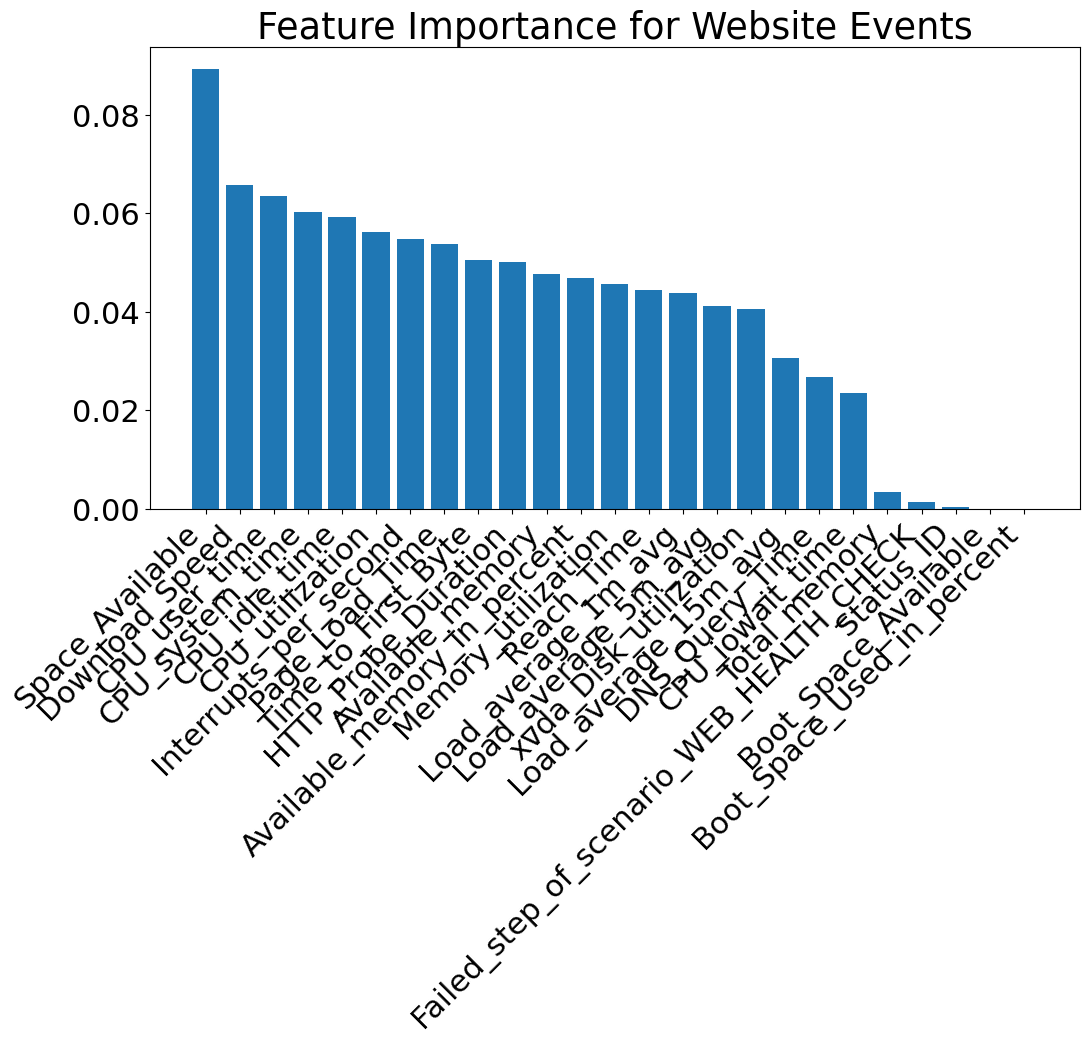

C:\Users\waqar.farooqui\AppData\Local\Temp\ipykernel_25112\2639939679.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


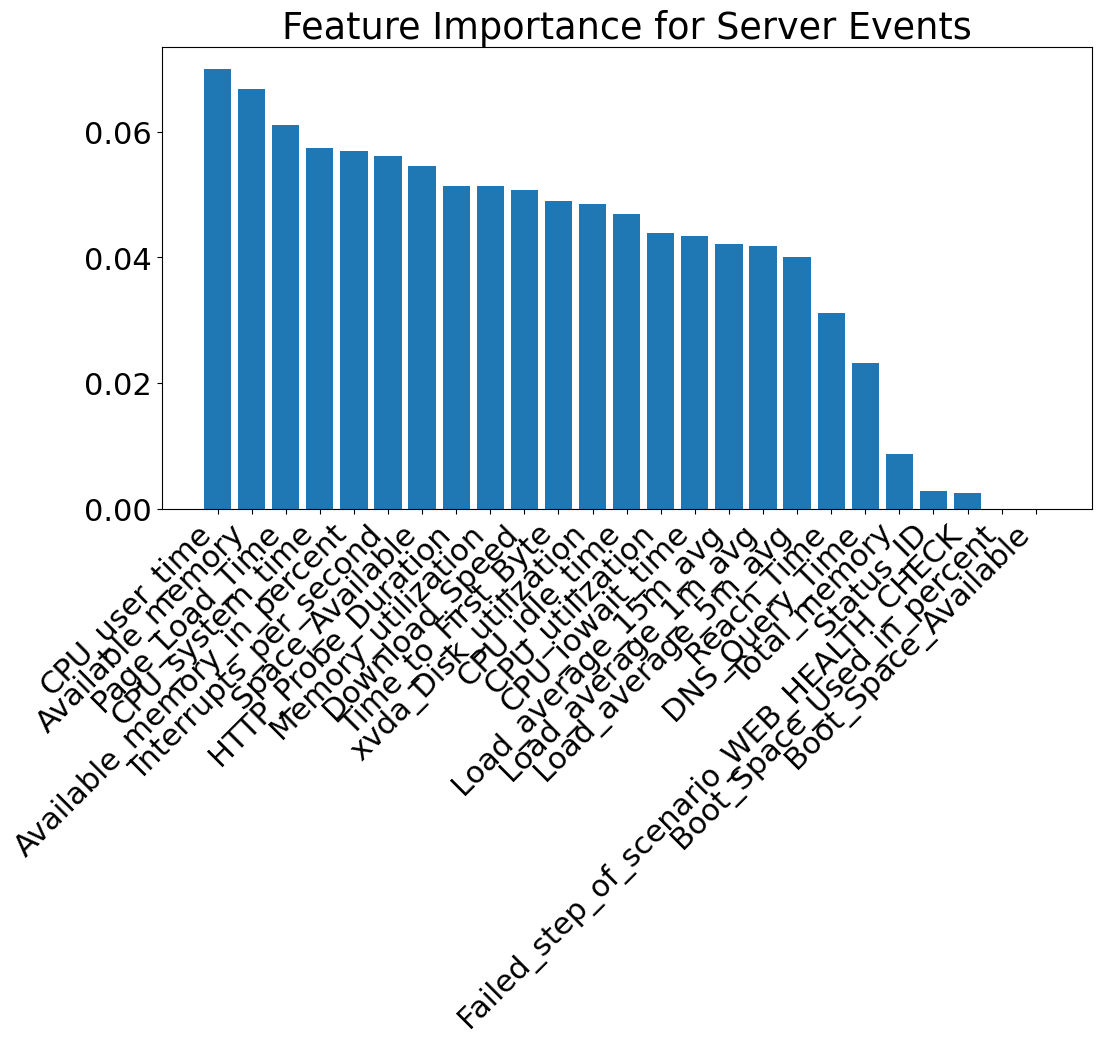

In [96]:
# Analyze which metrics are most important for predictions
def plot_feature_importance(model, feature_names, title):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(12, 6))
    plt.title(f"Feature Importance for {title}")
    plt.bar(range(len(indices)), importances[indices])
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

plot_feature_importance(website_model, feature_columns, "Website Events")
plot_feature_importance(server_model, feature_columns, "Server Events")

In [97]:
# import joblib

# # Save models and scalers
# joblib.dump(website_model, 'website_model.joblib')
# joblib.dump(server_model, 'server_model.joblib')
# joblib.dump(scaler, 'scaler.joblib')
# joblib.dump(le_website, 'le_website.joblib')
# joblib.dump(le_server, 'le_server.joblib')

['le_server.joblib']

Available metrics: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


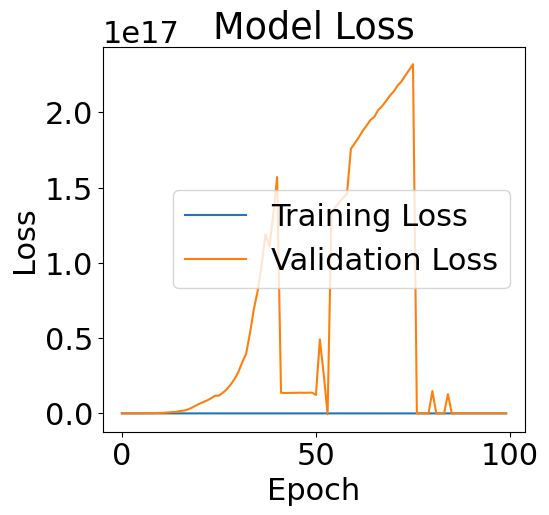

In [80]:
history_dict = history.history

# Print available metrics
print("Available metrics:", history_dict.keys())

# Create subplots
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

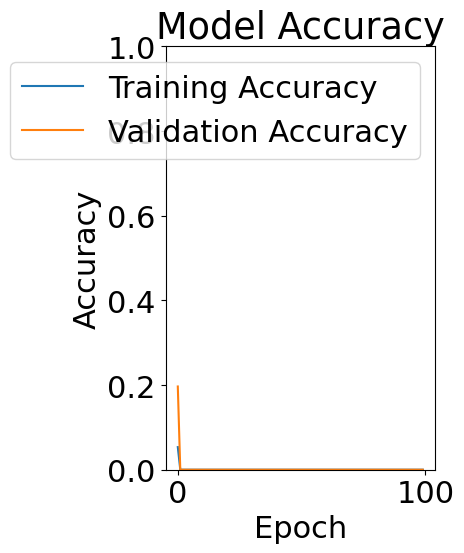

In [81]:
plt.subplot(1, 2, 2)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0., 1.])
plt.legend()

plt.tight_layout()
plt.show()


Available metrics: dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


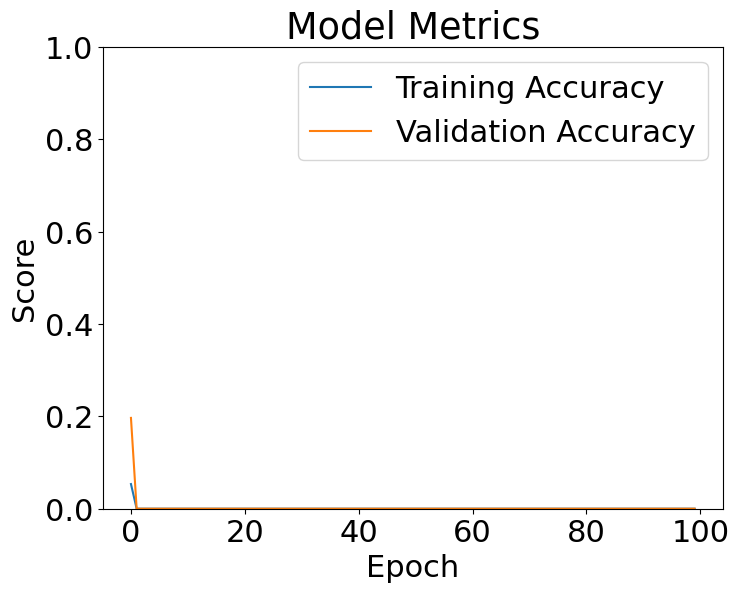

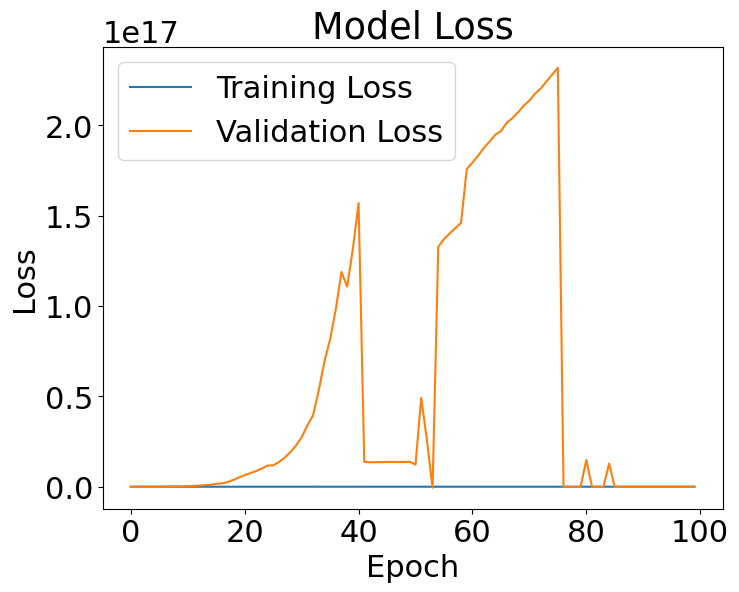

In [84]:
# First, let's see what metrics are available
print("Available metrics:", history_dict.keys())

# Plot metrics
plt.figure(figsize=(8, 6))
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.title('Model Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim([0., 1.])
plt.legend()
plt.show()

# Plot loss separately
plt.figure(figsize=(8, 6))
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [85]:
# First, let's see what metrics are available
print("Available metrics:", history.keys())

# Plot available metrics
plt.figure(figsize=(8, 6))
plt.plot(history['binary_accuracy'], label='Training Accuracy')
plt.plot(history['val_binary_accuracy'], label='Validation Accuracy')
# plt.plot(history['recall'], label='Recall')
# plt.plot(history['val_recall'], label='Validation Recall')
plt.title('Model Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim([0., 1.])
plt.legend()
plt.show()

AttributeError: 'History' object has no attribute 'keys'

Available metrics: dict_keys(['accuracy', 'binary_accuracy', 'false_positives_1', 'loss', 'recall_1', 'val_accuracy', 'val_binary_accuracy', 'val_false_positives_1', 'val_loss', 'val_recall_1'])


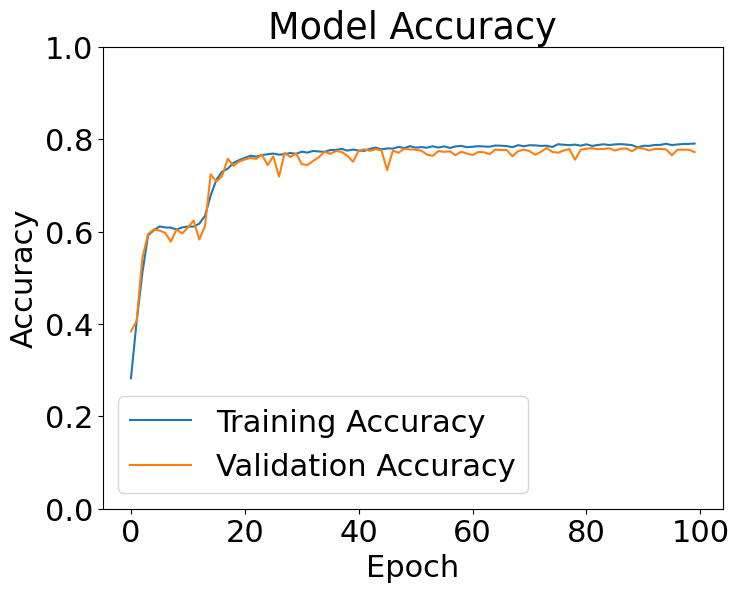

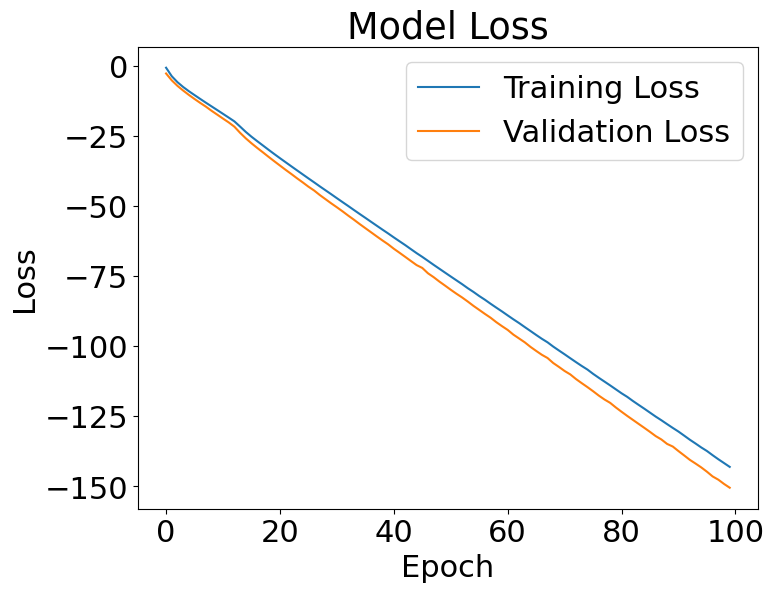

In [27]:
# First, let's see what metrics are available
print("Available metrics:", history.keys())

# Plot metrics
plt.figure(figsize=(8, 6))
plt.plot(history['binary_accuracy'], label='Training Accuracy')
plt.plot(history['val_binary_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0., 1.])
plt.legend()
plt.show()

# Plot loss separately
plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [30]:
model = Sequential()
model.add(Input(shape=(TIMESTEPS, N_FEATURES),
                name='input'))
model.add(
    LSTM(units=16,
         activation='relu',
         recurrent_activation='sigmoid',
         return_sequences=True,
         name='lstm_layer_1'))
model.add(
    LSTM(units=8,
         activation='relu',
         recurrent_activation='sigmoid',
         return_sequences=False,
         name='lstm_layer_2'))
model.add(Dense(units=1,
                activation='sigmoid',
                name='output'))

model.summary()

# Modified compilation with Keras metrics
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  tf.keras.metrics.F1Score(),
                  tf.keras.metrics.FalsePositives()
              ])

history = model.fit(x=X_train_scaled,
                    y=y_train,
                    batch_size=128,
                    epochs=100,
                    validation_data=(X_valid_scaled, y_valid),
                    verbose=0).history

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_layer_1 (LSTM)             │ (None, 5, 16)          │         2,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_layer_2 (LSTM)             │ (None, 8)              │           800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,689 (14.41 KB)

 Trainable params: 3,689 (14.41 KB)

 Non-trainable params: 0 (0.00 B)

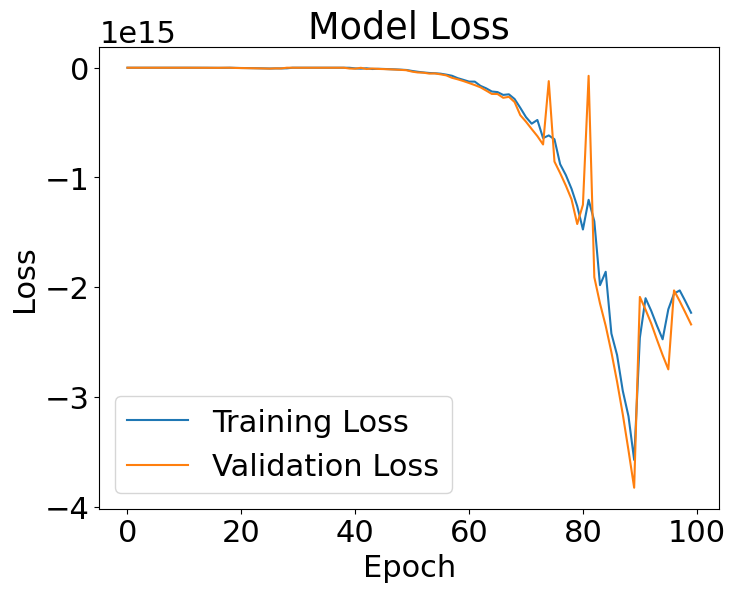

In [39]:
# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

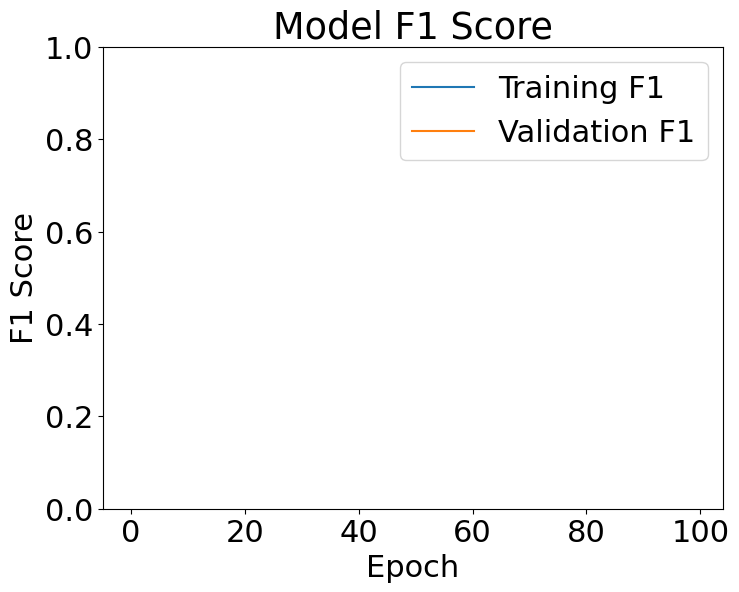

In [40]:
# Plot F1 Score
plt.figure(figsize=(8, 6))
plt.plot(history['f1_score'], label='Training F1')
plt.plot(history['val_f1_score'], label='Validation F1')
plt.title('Model F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0., 1.])
plt.legend()
plt.show()

Available metrics: dict_keys(['accuracy', 'f1_score', 'false_positives_2', 'loss', 'recall_3', 'val_accuracy', 'val_f1_score', 'val_false_positives_2', 'val_loss', 'val_recall_3'])


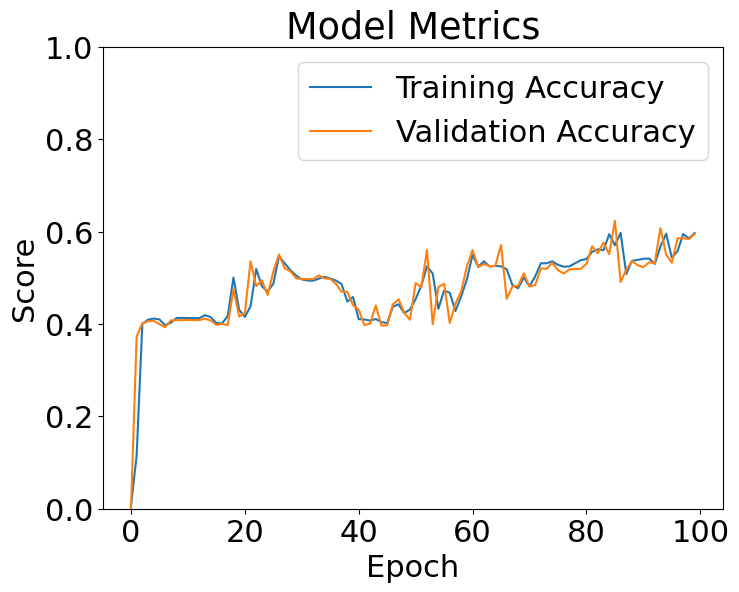

In [42]:
# First, let's see what metrics are available
print("Available metrics:", history.keys())

# Plot metrics
plt.figure(figsize=(8, 6))
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.ylim([0., 1.])
plt.legend()
plt.show()